# Kladd for sentimentanalyse

In [1]:
import dhlab as dh
import pandas as pd

wordcloud er ikke installert, kan ikke lage ordskyer


In [3]:
# Data import 
data_dir = "../norsentlex/Fullform/"
positive_tokens = pd.read_csv(data_dir + "/Fullform_Positive_lexicon.txt", names=["terms"])
negative_tokens = pd.read_csv(data_dir + "/Fullform_Negative_lexicon.txt", names=["terms"])

In [4]:
positive_tokens

,terms
0,absolutt
1,absolutta
2,absolutte
3,absoluttene
4,absolutter
...,...
6098,ønskete
6099,ønskt
6100,ønskte
6101,øyeblikkelig


In [5]:
negative_tokens

,terms
0,abnorm
1,abnorme
2,abnormt
3,abort
4,aborten
...,...
14834,ørlille
14835,ørlita
14836,ørlite
14837,ørliten


In [6]:
def count_sentiment_tokens(coll, terms):     
    
    target_terms = terms.join(coll, how="inner", on="terms")
    
    return target_terms

In [500]:
def group_index_terms(df: pd.DataFrame) -> pd.DataFrame:
    """Group duplicate index terms, make them case-insensitive, and sum up their frequency counts."""
    if hasattr(df, "frame"):
        df = df.frame
    df = df.loc[df.index.str.isalpha()]
    df.index = df.index.str.lower()
    df = df.groupby(df.index)["counts"].sum().to_frame("counts")
    return df

In [8]:
def label_sentiment_terms(coll, pos, neg):
    coll = group_index_terms(coll) 

    positive_counts = count_sentiment_tokens(coll, positive_tokens)
    negative_counts = count_sentiment_tokens(coll, negative_tokens)
    duplicates = pd.concat([coll, negative_counts, positive_counts], axis=1).index.drop_duplicates(keep=False).to_series(name="terms")
    neutral_counts = coll.join(duplicates, how="inner").reset_index(drop=True)

    positive_counts["sentiment"] = "pos"
    negative_counts["sentiment"] = "neg"
    neutral_counts["sentiment"] = "neut"

    sentlabels = pd.concat([positive_counts, negative_counts, neutral_counts], axis=0, ignore_index=True)
    
    return sentlabels

In [9]:
c = dh.Corpus(doctype="digavis", limit=10000)

In [10]:
coll = c.coll("barnevernet").frame

In [55]:
coll_case_insensitive = group_index_terms(coll)
coll_case_insensitive

There are duplicate collocation terms. Making terms case-insensitive.


,counts
index,
!,17
"""",9
#,2
%,2
&,6
...,...
”,2
„,1
•,13


In [51]:
df = coll_case_insensitive
df.counts.sum()
coll.counts.sum()

19720

In [44]:
coll[coll.index.duplicated()]

,counts
index,
arbeiderblad,1
av,4
barnet,1
barnevernet,6
bergo,1
...,...
øke,3
økonomi,3
økt,5


In [48]:
dupterm="barnevernet"

In [49]:
df.loc[dupterm]

counts    59
Name: barnevernet, dtype: int64

In [50]:
coll.loc[dupterm]

,counts
index,
barnevernet,1
barnevernet,6
barnevernet,52


In [53]:
df.index.nunique()

4623

-----
## Eksperimenter 

score concordance  og chunks istedet for collocations

In [ ]:
#!pip install -U dhlab
import os 
import datetime as dt
import pandas as pd

import dhlab as dh
from sentiment import *


In [ ]:

corpus_fil= "corpus_avis_2000_2021_Kristiansand_biblioteket_created2022-12-14.csv"
before=10
after=10
word="biblioteket"
words = word+",skolen"
word_list = make_list(words)


In [4]:
corpus = load_corpus_from_file(corpus_fil)

In [540]:
from collections import Counter
def strip_bold_annotation(text):
    return text.replace("<b>", "").replace("</b>", "")

# Functions to alter? 
def count_tokens(text):
    text = strip_bold_annotation(text)
    tokens = tokenize(text)
    newcoll = Counter([tok.lower() for tok in tokens if not tok=="..."])
    return pd.DataFrame({"token": newcoll.keys(), "counts": newcoll.values()})

def group_index_terms(df: pd.DataFrame) -> pd.DataFrame:
    """Group duplicate index terms, make them case-insensitive, and sum up their frequency counts."""
    if hasattr(df, "frame"):
        df = df.frame
    df = df.loc[df.index.str.isalpha()]
    df.index = df.index.str.lower()
    df = df.groupby(df.index).sum().to_frame("counts")
    return df

def count_matching_tokens(token_counts: pd.DataFrame, terms: pd.Series) -> pd.DataFrame:
    """Combine word counts with a series of terms."""
    target_terms = terms.join(token_counts, how="inner", on="terms")
    return target_terms


def score_sentiment(text, positive, negative):
    """Calculate a sentiment score for the contexts of ``word`` in a given publication (``URN``)."""
  #  coll = urn_collocation(urns=[urn], word=word, before=before, after=after)
   # coll = group_index_terms(coll)
    context = count_tokens(text)
    sent_counts = [count_matching_tokens(context, sent_terms).counts.sum()
        if not context.empty else 0
        for sent_terms in (positive, negative)
    ]
    return sent_counts


def count_and_score_target_words(corpus: dh.Corpus, words:str):
    """Add word frequency and sentiment score for each word in ``words`` to the given ``corpus``."""
    words=make_list(words)
    urnlist = corpus.corpus.urn.to_list()
    limit = 60*len(urnlist)
    conc = concordance(urnlist, word, window=200, limit=limit)
    word_freq=count_terms_in_doc(urnlist, words)

    pos, neg = load_norsentlex()
    #concs = concordance(..)
    word_freq[["positive", "negative"]] = conc.apply(lambda x: score_sentiment(x.conc, pos, neg), axis=1, result_type="expand")
    word_freq["sentimentscore"] = word_freq["positive"]-word_freq["negative"]
    df = corpus.frame.merge(word_freq, how="inner", left_on="urn", right_on="urn")
    df = strip_empty_cols(df)
    return df


def get_context_bow(urn, word):

    freq_col="counts"
    token_col = "token"
    par_idx_col = "paragraph"

    # Get a dataframe with all paragraphs in a URN and their word counts
    chunks  = get_chunks_para(urn)
    total = [{par_idx_col:i, token_col: token, freq_col: count} for i, para in enumerate(chunks) for token, count in para.items()]
    df = pd.DataFrame(total)

    # Filter dataframe on the paragraphs that contain the search word 
    df["lowercase"] = df[token_col].str.lower()
    matching_paragraphs = df[par_idx_col][df["lowercase"].str.match(word)]
    cdf = df[df.paragraph.isin(matching_paragraphs)]
    context = cdf[freq_col]
    context.index = cdf[token_col]
    context = group_index_terms(context)
    return context



def compute_sentiment_analysis(*args, **kwargs):
    """Compute sentiment score on the input data."""
    return count_and_score_target_words(*args, **kwargs)


In [541]:
result = compute_sentiment_analysis(corpus, word)

ConnectTimeout: HTTPSConnectionPool(host='api.nb.no', port=443): Max retries exceeded with url: /dhlab/conc (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f6963fe8d60>, 'Connection to api.nb.no timed out. (connect timeout=None)'))

In [577]:
r = result[["year","positive", "negative", "sentimentscore"]]

In [572]:
r = result[["title", "city", "timestamp", "year","positive", "negative", "sentimentscore"]]
r.index = result.urn

<AxesSubplot: xlabel='title'>

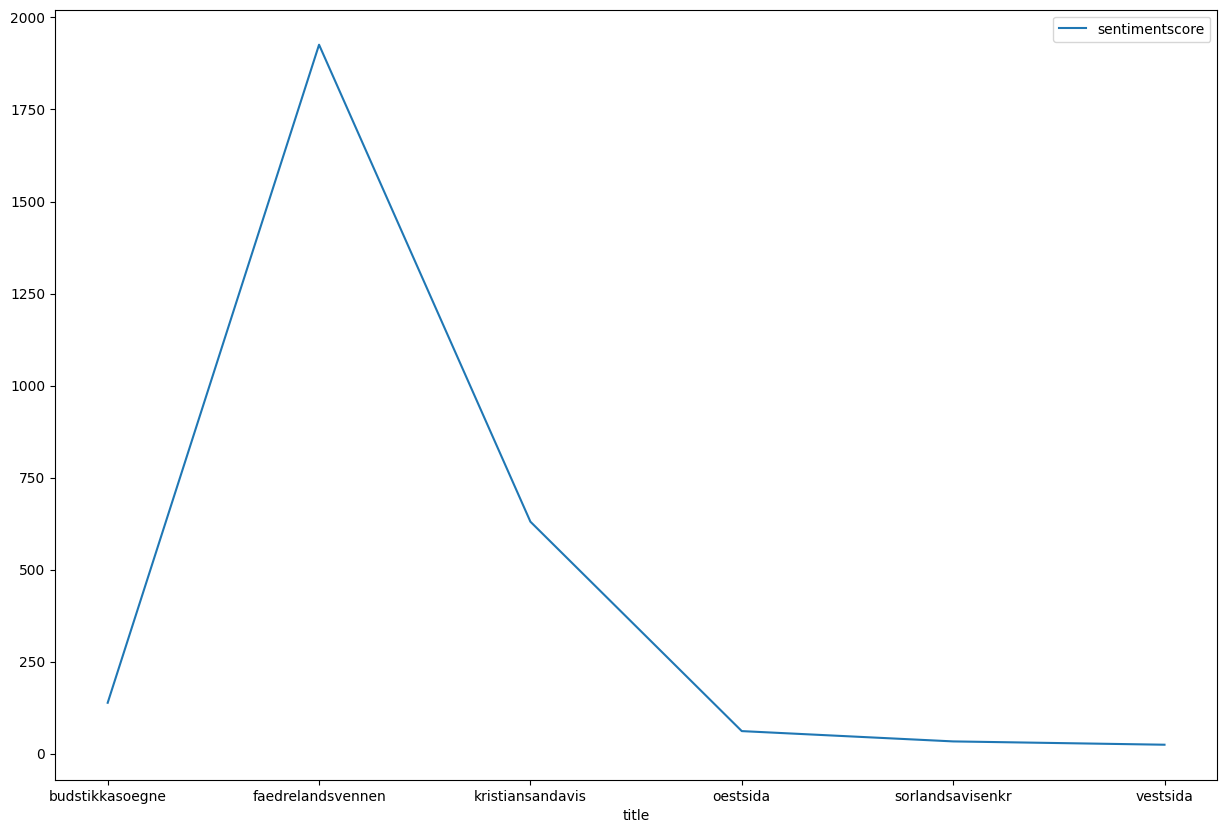

In [573]:
r.groupby("title")[["sentimentscore"]].sum().plot()

<AxesSubplot: xlabel='year'>

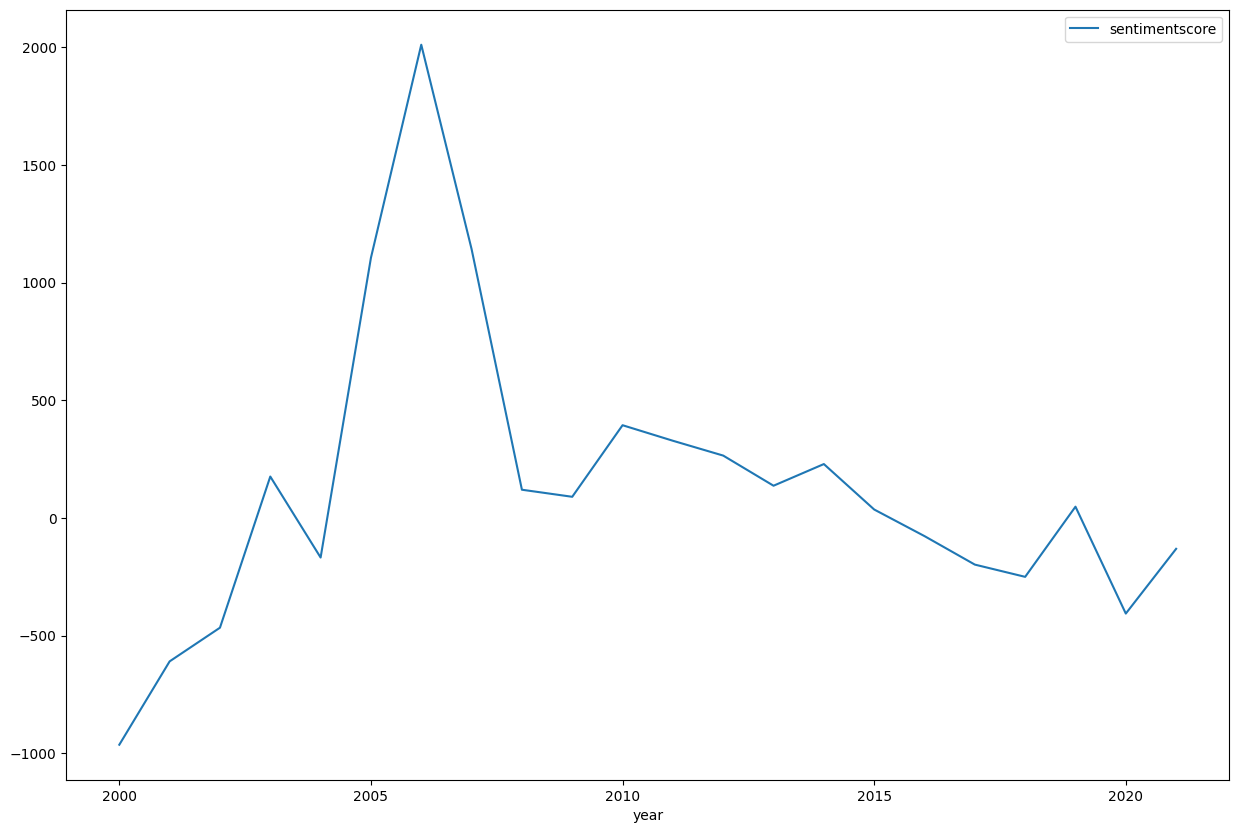

In [574]:
r.groupby("year")[["sentimentscore"]].sum().plot()

<AxesSubplot: xlabel='year'>

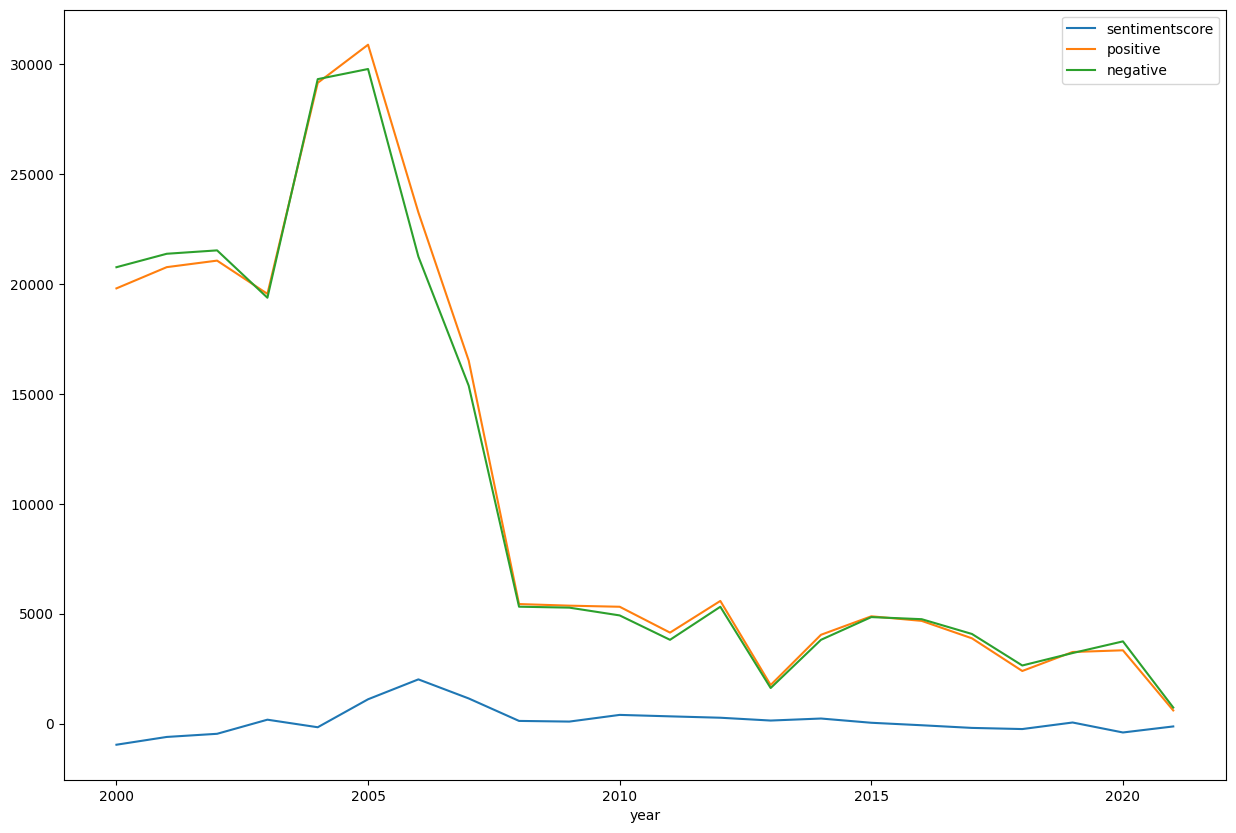

In [576]:
rgroup = r.groupby("year")[["sentimentscore", "positive", "negative"]].sum() 
rgroup.plot()

In [460]:
from dhlab import token_map
from dhlab.nbtokenizer import tokenize

from dhlab.text.conc_coll import find_hits
from dhlab.api.dhlab_api import concordance, concordance_counts


In [ ]:
urnlist = list(corpus.corpus.urn)

In [479]:
limit = 60*len(urnlist)
window = 100

In [480]:

(conc := concordance(urnlist, word, window=window, limit=limit))

,docid,urn,conc
0,201936433,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Siden våi ; en 2005 har <b>skolen</b> deltatt ...
1,201936433,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Utgangspunktet vårt var at skolegården faktisk...
2,201936433,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... I den forbindelse har <b>skolen</b> en del...
3,201936433,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... september gikk hele <b>skolen</b> inn til ...
4,201936433,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... <b>Skolen</b> og nærmiljøet på Tinnheia sk...
...,...,...,...
26735,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Han vil stramme inn muligheten for å få fr...
26736,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Nå brenner han for og legger bedre til ret...
26737,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,KROPPSØVING . Mange elever liker ikke kroppsøv...
26738,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,Selv opplevde han gymtimene da han gikk på <b>...


In [461]:
(concount := concordance_counts(urnlist, word))

,freq
!,732
"""",297
#,26
$,8
%,134
...,...
★,1
♦,3
✓,2
➜,1


In [447]:
(conc := dh.Concordance(corpus, word, window=window, limit=limit).concordance)

,link,urn,concordance
0,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Siden våi ; en 2005 har <b>skolen</b> deltatt ...
1,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Utgangspunktet vårt var at skolegården faktisk...
2,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... I den forbindelse har <b>skolen</b> en del...
3,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... september gikk hele <b>skolen</b> inn til ...
4,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... <b>Skolen</b> og nærmiljøet på Tinnheia sk...
...,...,...,...
26735,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Han vil stramme inn muligheten for å få fr...
26736,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Nå brenner han for og legger bedre til ret...
26737,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,KROPPSØVING . Mange elever liker ikke kroppsøv...
26738,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,Selv opplevde han gymtimene da han gikk på <b>...


In [448]:
(conc := corpus.conc(word, window=window, limit=limit).concordance)

,link,urn,concordance
0,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Siden våi ; en 2005 har <b>skolen</b> deltatt ...
1,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,Utgangspunktet vårt var at skolegården faktisk...
2,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... I den forbindelse har <b>skolen</b> en del...
3,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... september gikk hele <b>skolen</b> inn til ...
4,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_vestsida_null_null_20061...,... <b>Skolen</b> og nærmiljøet på Tinnheia sk...
...,...,...,...
26735,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Han vil stramme inn muligheten for å få fr...
26736,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,... Nå brenner han for og legger bedre til ret...
26737,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,KROPPSØVING . Mange elever liker ikke kroppsøv...
26738,<a target='_blank' href = 'https://urn.nb.no/U...,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,Selv opplevde han gymtimene da han gikk på <b>...


In [495]:
# concordance from api 
urn = conc.urn[0]
texts = conc.conc[conc.urn == urn]

(text := texts[0])

'Siden våi ; en 2005 har <b>skolen</b> deltatt i det kommunale prosjektet ” Aktiv ute ” . Det er et prosjekt som har som mål å øke... '

In [ ]:
# conc from dhlab objects 
conc = conc.concordance
urn = conc.urn[0]
texts = conc.concordance[conc["urn"] == urn]


(text := texts[0])

In [459]:
texts

0     Siden våi ; en 2005 har <b>skolen</b> deltatt ...
1     Utgangspunktet vårt var at skolegården faktisk...
2     ... I den forbindelse har <b>skolen</b> en del...
3     ... september gikk hele <b>skolen</b> inn til ...
4     ... <b>Skolen</b> og nærmiljøet på Tinnheia sk...
5     ... flyttet dit , og Karl Johans Minne ble en ...
6     Mottoet for <b>skolen</b> vår er " Et vokseste...
7                             <b>Skolen</b> på toppen !
8     ... Dette vet <b>skolen</b> å utnytte i sin un...
9     <b>Skolen</b> kjennetegnes av et godt og trygt...
10    ... Elevene tar seiv ansvaret for kildesorteri...
11    Da krigen kom , sluttet han på <b>skolen</b> ,...
Name: concordance, dtype: object

In [498]:


text = strip_bold_annotation(text)
tokens = tokenize(text)

len(tokens), tokens 

(28,
 ['Siden',
  'våi',
  ';',
  'en',
  '2005',
  'har',
  'skolen',
  'deltatt',
  'i',
  'det',
  'kommunale',
  'prosjektet',
  '”',
  'Aktiv',
  'ute',
  '”',
  '.',
  'Det',
  'er',
  'et',
  'prosjekt',
  'som',
  'har',
  'som',
  'mål',
  'å',
  'øke',
  '...'])

In [534]:
from collections import Counter



In [499]:
conc.urn.nunique()

3331

In [453]:
corpus_df = strip_empty_cols(corpus.corpus)

In [454]:
(corpconcdf := corpus_df.merge(conc.drop(columns="link"), how="inner", left_on="urn", right_on="urn"))


,dhlabid,urn,title,city,timestamp,year,doctype,concordance
0,200881785,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,kristiansandavis,Kristiansand,20100107,2010,digavis,... Og <b>skolen</b> ønsker gjerne å utvikle v...
1,200881785,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,kristiansandavis,Kristiansand,20100107,2010,digavis,... Her prøver <b>skolen</b> ut alternativ bel...
2,200881786,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,kristiansandavis,Kristiansand,20100114,2010,digavis,- Det er mitt hjertebarn og jeg skal jobbe med...
3,200881786,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,kristiansandavis,Kristiansand,20100114,2010,digavis,den <b>skolen</b> etter Kringsjå skole som har...
4,200881787,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,kristiansandavis,Kristiansand,20100121,2010,digavis,... Vi ser det også som svært positivt at <b>s...
...,...,...,...,...,...,...,...,...
26735,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20200227,2020,digavis,... Han vil stramme inn muligheten for å få fr...
26736,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20200227,2020,digavis,... Nå brenner han for og legger bedre til ret...
26737,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20200227,2020,digavis,KROPPSØVING . Mange elever liker ikke kroppsøv...
26738,200486873,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20200227,2020,digavis,Selv opplevde han gymtimene da han gikk på <b>...


In [491]:
text = texts[0]

hits = find_hits(text)
text = strip_bold_annotation(text)

In [492]:
text

'- Det er mitt hjertebarn og jeg skal jobbe med det til målene våre er nådd , nemlig at skolen er økonomisk bærekraftig , sier... '

In [478]:
(tokens := tokenize(text))

['Siden',
 'våi',
 ';',
 'en',
 '2005',
 'har',
 'skolen',
 'deltatt',
 'i',
 'det',
 'kommunale',
 'prosjektet',
 '”',
 'Aktiv',
 'ute',
 '”',
 '.',
 'Det',
 'er',
 'et',
 'prosjekt',
 'som',
 'har',
 'som',
 'mål',
 'å',
 'øke',
 '...']

## Try with chunks

In [511]:
from dhlab import Chunks
from dhlab.api.dhlab_api import get_chunks, get_chunks_para


word = "skolen"
urn = corpus.frame.loc[1, "urn"]

freq_col="counts"
token_col = "token"
par_idx_col = "paragraph"


In [512]:
# Get a dataframe with all paragraphs in a URN and their word counts
chunks  = get_chunks_para(urn)
total = [{par_idx_col:i, token_col: token, freq_col: count} for i, para in enumerate(chunks) for token, count in para.items()]
df = pd.DataFrame(total)

In [570]:
df

,paragraph,token,counts,lowercase
0,0,(,1,(
1,0,),1,)
2,0,2.,1,2.
3,0,921,2,921
4,0,Tomme,1,tomme
...,...,...,...,...
12592,751,sterkere,1,sterkere
12593,751,til,1,til
12594,751,tilknytning,1,tilknytning
12595,751,to,1,to


In [517]:
# Filter dataframe on the paragraphs that contain the search word 

df["lowercase"] = df[token_col].str.lower()
matching_paragraphs = df[par_idx_col][df["lowercase"].str.match(word)]
cdf = df[df.paragraph.isin(matching_paragraphs)]
context = cdf[freq_col]
context.index = cdf[token_col]
context = group_index_terms(context)

context

,counts
token,
arbeid,1
arbeidsdager,1
at,2
av,1
bare,1
barn,1
barnehager,1
besøkte,1
betyr,1


In [467]:
(para_count := [ch for ch in chunks  ])

[{',': 3,
  '-': 1,
  '.': 1,
  'Det': 1,
  'arbeidsdager': 1,
  'at': 2,
  'blir': 1,
  'bærekraftig': 1,
  'det': 2,
  'enn': 1,
  'er': 3,
  'et': 1,
  'hjertebarn': 1,
  'hun': 1,
  'i': 1,
  'ikke': 1,
  'jeg': 1,
  'jobbe': 1,
  'legger': 1,
  'med': 1,
  'men': 1,
  'mer': 1,
  'mitt': 1,
  'målene': 1,
  'nemlig': 1,
  'nådd': 1,
  'og': 1,
  'par': 1,
  'sier': 1,
  'skal': 1,
  'skolen': 1,
  'til': 2,
  'uken': 1,
  'våre': 1,
  'økonomisk': 1},
 {',': 1,
  '.': 1,
  'Kringsjå': 1,
  'Rajshahi': 1,
  'Skoler': 1,
  'arbeid': 1,
  'av': 1,
  'barn': 1,
  'barnehager': 1,
  'betyr': 1,
  'bli': 1,
  'de': 1,
  'den': 2,
  'det': 1,
  'er': 1,
  'et': 1,
  'etter': 1,
  'for': 2,
  'får': 1,
  'gjort': 1,
  'gleden': 1,
  'godt': 1,
  'har': 2,
  'inn': 1,
  'inntekt': 1,
  'insats': 1,
  'lagt': 1,
  'meget': 1,
  'mest': 1,
  'motatt': 1,
  'mye': 1,
  'ned': 1,
  'og': 3,
  'samlet': 1,
  'skole': 1,
  'skolen': 1,
  'som': 4,
  'stort': 1,
  'til': 1,
  'under': 1,
  'unge'

In [569]:
chunks[1]

{'*': 1,
 ',': 1,
 '-': 1,
 '.': 2,
 'Ikke': 1,
 'Jeg': 1,
 'Jte': 1,
 'Kristiansand': 1,
 'alle': 1,
 'at': 1,
 'bare': 1,
 'chill': 1,
 'det': 1,
 'et': 1,
 'feste': 1,
 'forventer': 1,
 'gøy': 1,
 'ha': 1,
 'i': 1,
 'mange': 1,
 'med': 2,
 'men-': 1,
 'nesker': 1,
 'noe': 1,
 'og': 4,
 'overraskelser': 1,
 'skal': 1,
 'stress': 1,
 'være': 1,
 'år': 1}

In [468]:
(s := sum([ch.get(word,0) for ch in para_count]) )

2

In [472]:
hits = [{"paragraph":i, "token": token, "count": count} for i, para in enumerate(chunks) if word in para for token, count in para.items()]

hits_df = pd.DataFrame(hits)

In [474]:
len(hits), urn, s

(79, 'URN:NBN:no-nb_digavis_kristiansandavis_null_null_20100114_4_2_1', 2)

In [475]:
chunks_df = pd.DataFrame(chunks)

In [476]:
chunks_df.sum()

,           599.0
-           338.0
.           881.0
Blir          1.0
Bromwich      8.0
            ...  
PA            1.0
TrT           1.0
jrajflß       1.0
lis           1.0
tttH          1.0
Length: 4166, dtype: float64

In [477]:
count_terms_in_doc([urn], word)

,urn,word,count
0,URN:NBN:no-nb_digavis_kristiansandavis_null_nu...,skolen,2
